# J(oint)-PCMCI$^+$: Causal discovery for time series from multiple (possibly latent) contexts

TIGRAMITE is a time series analysis python module. It allows to reconstruct causal graphical models from discrete or continuously-valued time series based on the PCMCI framework and create high-quality plots of the results.

This tutorial explains the Joint-PCMCI$^+$ (J-PCMCI$^+$) algorithm, which is implemented as the function ```J_PCMCI.run_jpcmciplus```. J-PCMCI$^+$ is specifically designed to handle time series data from different datasets that include time series observations of the same variables (system-variables), but that were collected in different contexts. While also the PCMCI and PCMCIplus algorithms can handle multiple datasets by simply pooling them, J-PCMCI+ allows to characterize the contexts by specific context-variables and can learn 1) how these contexts cause the system variables and 2) deconfound spurious system-variable links due to observed as well as latent contexts.

* * * * *
Publication on J-PCMCI$^+$: Günther, Wiebke, and Ninad, Urmi and Runge, Jakob (2023). Causal discovery for time series from multiple datasets with latent contexts. Accepted at 39th Conference on Uncertainty in Artificial Intelligence 2023.
https://arxiv.org/abs/2306.12896
* * * * *

The tutorial covers the following:
1. Motivation and basic concepts
2. The algorithm
3. Application example

In [1]:
# Imports
import numpy as np
from numpy.random import SeedSequence
from matplotlib import pyplot as plt

import tigramite
from tigramite.toymodels import structural_causal_processes as toys
from tigramite.toymodels.context_model import ContextModel
from tigramite.jpcmciplus import JPCMCIplus
from tigramite.independence_tests.parcorr_mult import ParCorrMult
from tigramite.independence_tests.regressionCI import RegressionCI
import tigramite.data_processing as pp
import tigramite.plotting as tp

## 1. Motivation and basic concepts

We are interested in discovering the causal graph between variables that we have observed within different contexts, i.e., we have different datasets with observational time series of these variables (see schematic below). For instance, such contexts can be different locations at which we have observed these variables, such as time series of river runoff and local weather variables from different catchments. 

<img style="float: left; margin:10px 30px 0 0" src="./figures/intro_jpcmci.png" alt= “” width="30%" height="30%">

In this example, the local catchment systems share certain causal influences, such as time-dependent large-scale weather over all catchments, but differ in other catchment-specific but constant-in-time drivers, such as the altitude of the catchment. We call these drivers ***temporal*** and ***spatial contexts*** ($\tilde{C}_\text{time}$ and $\tilde{C}_\text{space}$ in the schematic), respectively. They differ from the ***system variables*** (runoff, local weather variables such as precipitation) in the sense that some background knowledge on their structure and on their relationship to the system variables is available. In particuar, we assume the context variables to be either constant in time and varying over the datasets, or varying in time and constant over the datasets. Furthermore, we assume them to be exogenous to the system variables.

These assumptions allow us to learn how contexts affect system variables as well as overcome latent confounding that is due to unobserved context variables by pooling the datasets and considering the joint causal graph among system, context, and certain auxiliary variables as we will see in more detail in the following sections of this tutorial.



***To summarize***, in this tutorial we take a look at J-PCMCI$^+$, which is a consistent causal discovery algorithm that can:

   1. de-confound those system nodes that are confounded by latent contexts without having any knowledge of the latent contexts themselves;
   2. retain as much information about the causal links between the observed  context and system variables as possible by checking conditional independencies appropriately;
   3. discover the correct induced causal graph between the system nodes.

### 1.1 The joint time-dependent  structural causal model

To formalize the ideas presented above, we assume that the observed data was generated by an underlying mechanism across datasets $d\in \mathcal{D}$ with $|\mathcal{D}|=M$ that can be represented by an acyclic time-dependent structural causal model (SCM) involving the time-dependent system variables $\mathbf{X}_t=\{X_t^i\}_{i\in \mathcal{I}}$ at time $t$ as well as context variables $\tilde{\mathbf{C}}=\tilde{\mathbf{C}}_{time}\dot{\cup} \ 
    \tilde{\mathbf{C}}_{space}$ with temporal contexts $\tilde{\mathbf{C}}_{time,t}=\{\tilde{C}_t^k\}_{k\in \mathcal{K}_{\rm time}}$ and (time-independent) spatial-contexts $\tilde{\mathbf{C}}_{space}=\{\tilde{C}^l\}_{l\in \mathcal{K}_{\rm space}}$, for $i\in \mathcal{I}$:
    
\begin{aligned}
            &\mathbf{X}^{d}_t:= \mathbf{f}({Pa}_X(\mathbf{X}^{d}_t),\operatorname{Pa}_{\tilde{C}_{\rm time}}(\mathbf{X}^{d}_t), \operatorname{Pa}_{\tilde{C}_{\rm space}}(\mathbf{X}^{d}_t), \boldsymbol{\eta}^{d}_t) \\ 
            &\mathbf{\tilde{C}}_{{\rm time}, t} := \mathbf{g}({Pa}_{\tilde{C}_{\rm time}}(\mathbf{\tilde{C}}_{{\rm time}, t}), \boldsymbol{\eta}_{{\rm time}, t}) \\
            &\mathbf{\tilde{C}}^{d}_{\rm space} := \mathbf{h}({Pa}_{\tilde{C}_{\rm space}}(\mathbf{\tilde{C}}_{\rm space}), \boldsymbol{\eta}_{\rm space}^{d})
\end{aligned}
 where the exogenous noise variables $(\boldsymbol{\eta}^{d}_t, \boldsymbol{\eta}_{{\rm time}, t}, \boldsymbol{\eta}_{\rm space}^{d})$ are jointly independent and $\eta^{i,d}_{t}$ are identically distributed across time and space, $\eta^k_{{\rm time},t}$ are identically distributed across time, and $\eta^{l,d}_{\rm space}$ are identically distributed across space. $\operatorname{Pa}_X$ denotes the causal parents within $\mathbf{X}$, and analogously for $\operatorname{Pa}_{\tilde{C}_{\rm time}}$ and $\operatorname{Pa}_{\tilde{C}_{\rm space}}$.
 
Note that we assume that the context variables are exogeneous to the system. In other words, system variables cannot be parents of context variables.


### 1.2 Context variables and dummy variables

Let us take a closer look at the context variables $\tilde{\mathbf{C}}_\text{time}$ and $\tilde{\mathbf{C}}_\text{space}$ in the SCM above. 

A temporal context variable $C^i_\text{time} \in \tilde{\mathbf{C}}_\text{time}$ is a time-dependent random variable that remains the same across datasets. A spatial context variable $C^i_\text{space} \in \tilde{\mathbf{C}}_\text{space}$ is a random variable that is constant over time and within a dataset but can change across datasets. (A context that various over both time and datasets is rather a system variable.) In our motivational example,$C^i_\text{time}$ could represent large-scale weather dynamics that affect multiple observational sites at once. Another example could be the economic development in a country over a time that affects all individuals living in that country. An example for $C^i_\text{space}$ could be the average slope in a river catchment or the height of an individual. 
We think of the context variables as corresponding to real-world phenomena. 

However, J-PCMCI+ can also deal with unobserved context variables. This is achieved through auxiliary variables, so-called dummies that mimic the structure of context variables. These dummy variables label each time-step or dataset, respectively (and thus the time dummy has a unique value for each time step, and the space dummy has a unique value within each dataset). Generally, their values can not be interpreted as a physical quantity. In that sense, the dummy variable is not a causal variable itself. They are intended to be a placeholder for the unobserved context variables, in order to capture confounding between system variables due to latent context variables. 

Within J-PCMCI+, the dummy variables are encoded using one-hot vectors, i.e., for the time dummy the first time point has the corresponding dummy-value $(1,0,\ldots,0)^T \in \{ 0,1 \}^T$, the second time point corresponds to $(0,1,\ldots,0)^T$, and so on. For the space dummy dataset $1$ corresponds to the dummy-value $(1,0,\ldots,0)^T \in \{ 0,1 \}^M$, etc.

## 2. The algorithm

J-PCMCI+ extends the PCMCI+ time series causal discovery algorithm to the case of datasets from multiple dataset- or time dependent contexts with potentially unobserved context confounders of the system variables. It does so by combining PCMCI+ with the JCI-approach [1], i.e., pooling datasets from multiple contexts, and adding observed context variables to the graph. Furthermore, it uses time- and space-dummy variables to account for latent context variables that confound system variables, similar to [2].


The method consists of four main steps: one $\text{PC}_1$ lagged phase and three MCI phases similar to PCMCI+. 

1. ***$\text{PC}_1$ lagged discovery phase: Discovery of supersets of the lagged parents of the system and observed temporal context nodes on all pairs $((C^i_{t-\tau}, X^j_t))_{\tau > 0}$ and $((X^i_{t-\tau}, X^j_t))_{\tau > 0}$, as well as $((C^i_{t-\tau}, C^i_t))_{\tau > 0}$.*** (The last set of pairs covers autocorrelation in time-contexts, spatial context nodes do not carry temporal information and can be ignored here.)

2. ***MCI skeleton phase on context-system pairs conditional on subsets of system and context nodes***, i.e. perform MCI tests for pairs $((C^i_{t-\tau}, X^j_t))_{\tau \geq 0}$,
   $$
         C_{t-\tau}^i \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^-_t(X_t^j)  \setminus \{ C_{t-\tau}^i \}, \hat{\mathcal{B}}^-_{t-\tau}(C_{t-\tau}^i)
   $$
with $\mathbf{S}$ denoting a subset of the contemporaneous adjacencies $\mathcal{A}_t(X_t^j)$ (among system or time-context variables) and where $\hat{\mathcal{B}}^-_t(X_t^j)$ are the lagged adjacencies from step one. If $C$ is a spatial context variable, we only have to test the contemporaneous pairs $(C_t^j, X_t^i)$, $(X_t^i, C_t^j)$ for all $i,j$. Remember that the space-context nodes are constant over time and therefore essentially don't have a time-dimension associated with them (so we could also drop the time index, i.e. $C^j_t = C^j$). That means there is an edge $C^j \rightarrow X_{t}^i$ in the joint time series graph if and only if there also exist edges $C^j \rightarrow X_{t-\tau}^i$ for all $\tau > 0$. Thus, if $C^j$ and $X_t^i$ are conditionally independent, all these links between $C^j$ and $X^i_{t-\tau}$ are also removed for all $\tau$.

3. ***MCI skeleton phase on all system-dummy pairs conditional on the superset of lagged links, the discovered contemporaneous context adjacencies, as well as on subsets of contemporaneous system links***, i.e. test for $(D, X_t^i)$, $(X_t^i, D)$ for all $i$ where $D$ stands for the time- and space-dummy respectively, i.e. test
    $$
    D \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^C_t(X_t^j)
    $$
    where $\mathbf{S} \subset \mathcal{A}_t(X_t^i)$ and $\hat{\mathcal{B}}^C_t(X_t^j)$ are the lagged and contextual adjacencies found in the previous step.
If $D$ and $X_t^j$ are found to be conditionally independence, links between $D$ and $X^j_{t-\tau}$ are removed for all $\tau$.
Using the exogeneity assumption, the context node is the parent in all system-context links.

4. ***MCI skeleton phase on all system pairs conditional on discovered lagged, context and dummy adjacencies, as well as on subsets of contemporaneous system links and orientation phase***. In more detail, we perform MCI test for pairs $((X^j_{t-\tau}, X_t^i))_{\tau \geq 0}$, $(X_t^i, X_t^j)$ for all $i, j$, i.e.
    $$
     X^i_{t-\tau} \perp\!\!\!\!\perp X_t^j | \mathbf{S}, \hat{\mathcal{B}}^{CD}_t(X_t^j)  \setminus \{ X_{t-\tau}^i \},  \hat{\mathcal{B}}^{CD}_t(X_{t-\tau}^i) 
    $$
    where $\mathbf{S} \subset \mathcal{A}_t(X_t^i)$ and $\hat{\mathcal{B}}^{CD}_t(X_t^j)$ are the lagged, contextual, and dummy adjacencies found in the previous steps.
Finally, all remaining edges (without expert knowledge) are oriented using the PCMCI$^+$ orientation phase while making use of all triples involving at most one context or dummy variable and two or three system variables as in the non-time series case.

## 3. Application Example
This section demonstrates and explains the application of J-PCMCI+ on synthetic data.

### 3.1 Setup 
Here we choose the random seed, how large of a sample we want to generate, and some other hyperparameters.

In [2]:
# Set seeds for reproducibility
seed = 12345
ss = SeedSequence(seed)
noise_seed = ss.spawn(1)[0]

random_state = np.random.default_rng(noise_seed)

# Choose the time series length and number of spatial contexts
T = 100
nb_domains = 50

transient_fraction=0.2
tau_max = 2
frac_observed = 0.5

### 3.2 Data generation
For generating synthetic data, we consider a specific version of the time-dependent SCM (1). Namely, within each dataset $d$ at time point $t$:
\begin{aligned}
X^{1,d}_t &= 0.3X^{1,d}_{t-1} + 0.6C^4_t + 0.9L_{t-1}^5 + \eta^{1,d}_t, \\
X^{2,d}_t &= 0.4X^{2,d}_{t-1} + 0.4C^4_{t-1} + \eta^{2,d}_t, \\
X^{3,d}_t &= 0.3X^{3,d}_{t-1} - 0.5X^{2,d}_{t-2} + 0.5L_{t-1}^5 + 0.6C^6 + \eta^{3,d}_t, \\
C^4_t &= \eta^4_t, \\
L_t^{5} &= \eta^{5}_t, \\
C^{6,d} &= \eta^{5,d}, \\
\end{aligned}
where the temporal context variables $C_t^4$ and $L_t^5$ have the same value within each dataset, and the spatial context variable $C^6$ is constant over time, $L_t^5$ is a hidden temporal context.

In [3]:
# Specify the model
def lin(x): return x

links = {0: [((0, -1), 0.3, lin), ((3, -1), 0.6, lin), ((4, -1), 0.9, lin)],
         1: [((1, -1), 0.4, lin), ((3, -1), 0.4, lin)],
         2: [((2, -1), 0.3, lin), ((1, -2), -0.5, lin), ((4, -1), 0.5, lin), ((5, 0), 0.6, lin)] ,
         3: [], 
         4: [], 
         5: []
            }

# Specify which node is a context node via node_type (can be "system", "time_context", or "space_context")
node_classification = {
    0: "system",
    1: "system",
    2: "system",
    3: "time_context",
    4: "time_context",
    5: "space_context"
}

# Specify dynamical noise term distributions, here unit variance Gaussians
noises = [random_state.standard_normal for j in range(6)]

contextmodel = ContextModel(links=links, node_classification=node_classification,
                            noises=noises, 
                            seed=seed)

data_ens, nonstationary = contextmodel.generate_data(nb_domains, T)

assert not nonstationary

system_indices = [0,1,2]
# decide which context variables should be latent, and which are observed
observed_indices_time = [4]
latent_indices_time = [3]

observed_indices_space = [5]
latent_indices_space = []

# all system variables are also observed, thus we get the following observed data
observed_indices = system_indices + observed_indices_time + observed_indices_space
data_observed = {key: data_ens[key][:,observed_indices] for key in data_ens}

We have a quick look at the ground truth graph that we now have specified and which corresponds to the SCM (1) above. For that we use the function ```tp.plot_graph```. The observed temporal and spatial context nodes are labelled as t-$C_i$ and s-$C_i$, respectively. Their latent counterparts are labelled as t-$L_i$ and s-$L_i$, respectively.

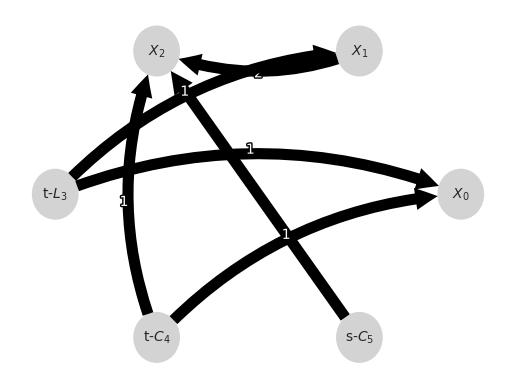

In [4]:
gt_graph = toys.links_to_graph(links, tau_max=tau_max)

sys_var_names = ['$X_%s$' % str(i) for i in system_indices]
temp_context_names = ['t-$L_%s$' % str(i) for i in latent_indices_time] + \
                     ['t-$C_%s$' % str(i) for i in observed_indices_time]

spatial_context_names = ['s-$L_%s$' % str(i) for i in latent_indices_space] \
                        + ['s-$C_%s$' % str(i) for i in observed_indices_space]
                            
tp.plot_graph(gt_graph, var_names=sys_var_names+temp_context_names+spatial_context_names)
plt.show()

The corresponding ground truth time series graph looks like this.

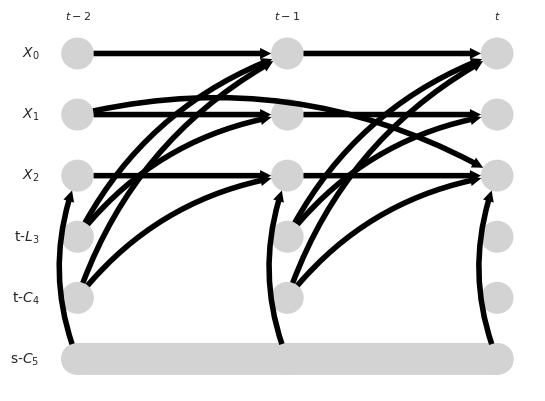

In [5]:
tp.plot_time_series_graph(gt_graph, 
                          var_names=sys_var_names+temp_context_names+spatial_context_names, 
                          node_classification=node_classification)
plt.show()

In [6]:
# Set up a suitable dummy and dataframe depending on which test one wants to use
# We start with the dummy for a variant of ParCorrMult: 
# For that, add one-hot-encoding of time-steps and dataset index to the observational data. 
# These are then the values of the time and space dummy variables.
dummy_data_time = np.identity(T)

data_dict = {}
for i in range(nb_domains):
    dummy_data_space = np.zeros((T, nb_domains))
    dummy_data_space[:, i] = 1.
    data_dict[i] = np.hstack((data_observed[i], dummy_data_time, dummy_data_space))

# Define vector-valued variables including dummy variables as well as observed (system and context) variables
nb_observed_context_nodes = len(observed_indices_time) + len(observed_indices_space)
N = len(system_indices)
process_vars = system_indices
observed_temporal_context_nodes = list(range(N, N + len(observed_indices_time)))
observed_spatial_context_nodes = list(range(N + len(observed_indices_time), 
                                            N + len(observed_indices_time) + len(observed_indices_space)))
time_dummy_index = N + nb_observed_context_nodes
space_dummy_index = N + nb_observed_context_nodes + 1
time_dummy = list(range(time_dummy_index, time_dummy_index + T))
space_dummy = list(range(time_dummy_index + T, time_dummy_index + T + nb_domains))

vector_vars = {i: [(i, 0)] for i in process_vars + observed_temporal_context_nodes + observed_spatial_context_nodes}
vector_vars[time_dummy_index] = [(i, 0) for i in time_dummy]
vector_vars[space_dummy_index] = [(i, 0) for i in space_dummy]

# Name all the variables and initialize the dataframe object
# Be careful to use analysis_mode = 'multiple'
sys_var_names = ['$X_%s$' % str(i) for i in process_vars]
context_var_names = ['t-$C_%s$' % str(i) for i in observed_indices_time] + ['s-$C_%s$' % str(i) for i in observed_indices_space]
var_names = sys_var_names + context_var_names + ['t-dummy', 's-dummy']

dataframe = pp.DataFrame(
    data=data_dict,
    vector_vars = vector_vars,
    analysis_mode = 'multiple',
    var_names = var_names
    )

# Now we set up the dummy and dataframe that are suitable for RegressionCI, RegressionCI does the one-hot-encoding under the hood: 
dummy_data_time_regr = np.linspace(0,T,T, endpoint=False).reshape((T,1))

data_dict_regr = {}
for i in range(nb_domains):
    dummy_data_space_regr = np.array([i for j in range(T)]).reshape((T,1))
    data_dict_regr[i] = np.hstack((data_observed[i], dummy_data_time_regr, dummy_data_space_regr))

# We also need to specify the data_type for RegressionCI, 0 is continuous and 1 discrete data
data_type =  np.zeros((50, 100, 7), dtype='int')
data_type[:, :, 5] = 1 # space context
data_type[:, :, time_dummy_index:] = 1 # dummies

dataframe_regr = pp.DataFrame(
    data=data_dict_regr,
    analysis_mode = 'multiple',
    data_type=data_type,
    var_names = var_names
    )

Let's look at the first two datasets by plotting the time series with the function ```tp.plot_timeseries```. Note that the observed spatial context variable ```s-C_5``` is constant across time but has a different value within each dataset, and the temporal context variable ```t-C_3``` has the same values in each dataset but it varies over time. 

We are not plotting the values of the dummy variables since these are very high-dimensional and not informative since they are just labelling the time steps and datasets, respectively.

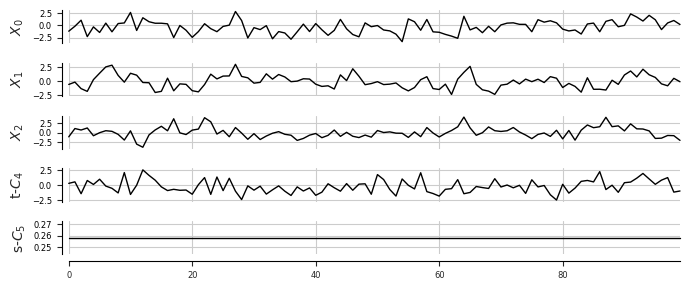

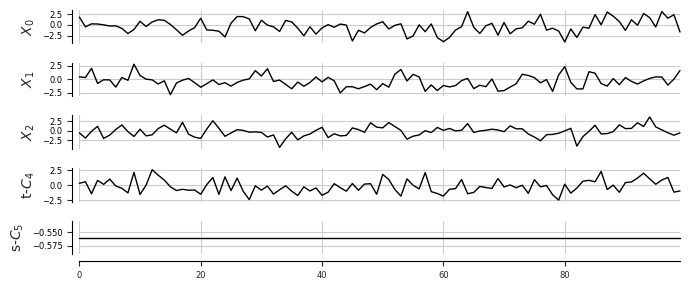

In [7]:
# only plot system variables and observed context variables
selected_variables=process_vars+observed_temporal_context_nodes+observed_spatial_context_nodes

for dataset in [0,1]:
    tp.plot_timeseries(selected_dataset = dataset, 
                       dataframe = dataframe, 
                       figsize=(7, 3), 
                       selected_variables=selected_variables)
    plt.show()

### Run J-PCMCI$^+$
We set ``tau_max = 2``. Heuristics for choosing this hyper parameter are described in the PCMCI tutorial. There, it is also described how to choose an appropriate conditional independence test based on density plots. We further choose ``pc_alpha = 0.01`` and leave all other hyperparameters as default settings.

As for PCMCIplus, the most important initilization parameters of the `JPCMCIplus` class are the `dataframe`, and the conditional independence test (`cond_ind_test`).
Additionally, `JPCMCIplus` also needs to know which of the variables are system variables, which are time-context or space-context variables, and the respective dummy nodes. This information is passed as a dictionary in the `node_classification` parameter.



###### 1. With a variant of ParCorrMult

In [8]:
# Categorize all the nodes into system, context, or dummy
node_classification_jpcmci = {i: node_classification[var] for i, var in enumerate(observed_indices)}
node_classification_jpcmci.update({time_dummy_index : "time_dummy", space_dummy_index : "space_dummy"})

# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
jpcmciplus = JPCMCIplus(dataframe=dataframe,
                          cond_ind_test=ParCorrMult(significance='analytic'), 
                          node_classification=node_classification_jpcmci,
                          verbosity=1,)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01

# Run J-PCMCI+
results = jpcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 3: {(3, -1): '-?>', (3, -2): '-?>', (5, 0): 'o?o', (6, 0): 'o?o'}, 4: {(5, 0): 'o?o', (6, 0): 'o?o'}, 5: {}, 6: {}}
independence test = par_corr_mult
tau_min = 1
tau_max = 

###### 2. With RegressionCI

In [10]:
# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.

jpcmciplus_regr = JPCMCIplus(dataframe=dataframe_regr,
                          cond_ind_test=RegressionCI(significance='analytic'),
                          node_classification=node_classification_jpcmci,
                          verbosity=2,)

# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01

# Run J-PCMCI+
results_regr = jpcmciplus_regr.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>', (5, 0): '-?>', (6, 0): '-?>'}, 3: {(3, -1): '-?>', (3, -2): '-?>', (5, 0): 'o?o', (6, 0): 'o?o'}, 4: {(5, 0): 'o?o', (6, 0): 'o?o'}, 5: {}, 6: {}}
independence test = regression_ci
tau_min = 1
tau_max = 

#### Plotting the results
Next, we use the function ```tp.plot_graph``` to plot the learned summary DAG. In our example the learned graph exactly agrees with the true DAG. 

Note, in particular, that J-PCMCI+ has correctly identified the links between the observed context variables and the system variables. It also managed to deconfound $X^0$ and $X^2$ which are confounded by an unobserved temporal context variable ($L^4_t$) using the time dummy.

The edges are colored according to the test statistic values returned by ```JPCMCIplus.run_jpcmciplus```, i.e., the maximum absolute value of ```val_matrix[i, j, tau]``` determines the color of the edge between $X^i_{t-\tau}$ and $X^j_t$ (provided this edge exists) according to the color scale at the bottom. The color of node denotes the maximum of the absolute value of ```val_matrix[i, i, tau]``` across all $1 \leq \tau \leq \tau_\text{max}$.


###### 1. With a variant of ParCorrMult

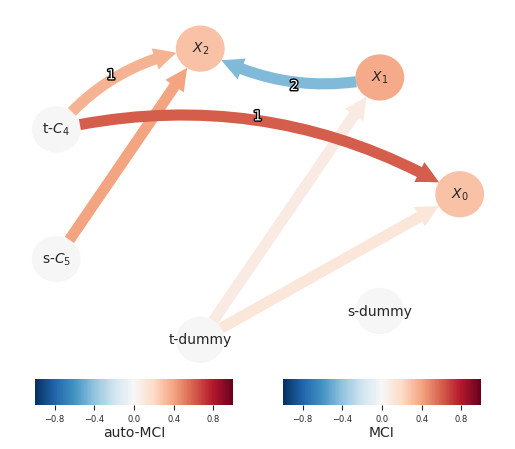

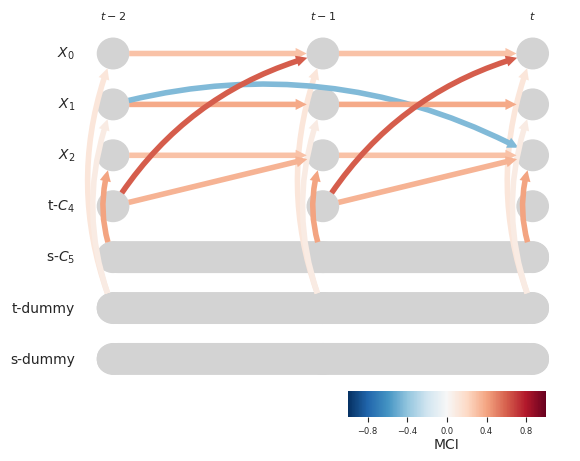

In [9]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
tp.plot_time_series_graph(results['graph'], val_matrix = results['val_matrix'], 
              node_classification = node_classification_jpcmci, var_names=var_names)
plt.show()

###### 2. With RegressionCI

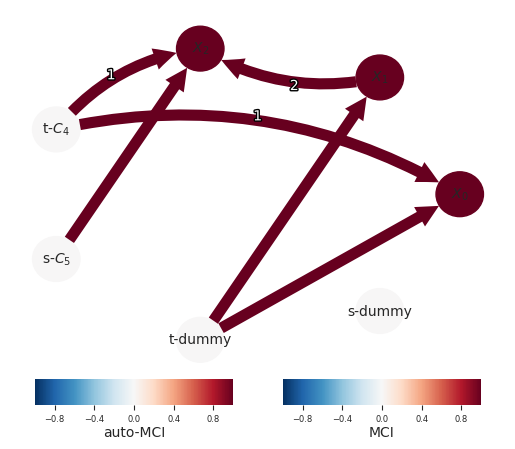

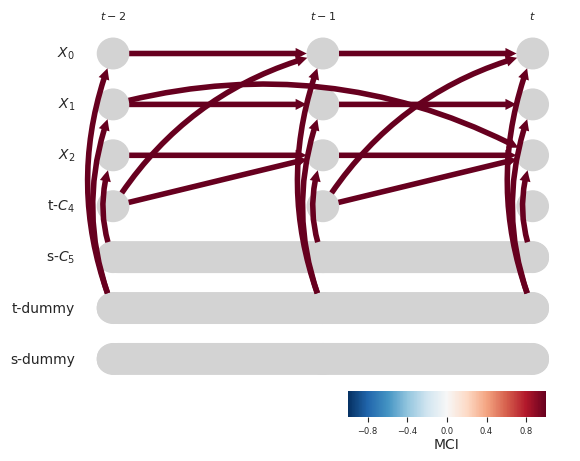

In [11]:
tp.plot_graph(results_regr['graph'], val_matrix=results_regr['val_matrix'], var_names=var_names)
tp.plot_time_series_graph(results_regr['graph'], val_matrix = results_regr['val_matrix'], 
              node_classification = node_classification_jpcmci, var_names=var_names)
plt.show()

If we do not include the dummy variables, we see that $X^1$ and $X^0$ are confounded.

In [12]:
# without dummy
# Classify all the nodes into system, context, or dummy
node_classification_jpcmci_wo_dummy = {i: node_classification[var] for i, var in enumerate(observed_indices)}

# Name all the variables and initialize the dataframe object
# Be careful to use analysis_mode = 'multiple'
var_names_wo_dummy = sys_var_names + context_var_names 


dataframe = pp.DataFrame(
    data=data_observed,
    analysis_mode = 'multiple',
    var_names = var_names_wo_dummy
    )

# Create a J-PCMCI+ object, passing the dataframe and (conditional)
# independence test objects, as well as the observed temporal and spatial context nodes 
# and the indices of the dummies.
jpcmciplus = JPCMCIplus(dataframe=dataframe,
                          cond_ind_test=ParCorrMult(significance='analytic'), 
                          verbosity=1,
                          node_classification=node_classification_jpcmci_wo_dummy)


# Define the analysis parameters.
tau_max = 2
pc_alpha = 0.01


# Run J-PCMCI+
results = jpcmciplus.run_jpcmciplus(tau_min=0, 
                              tau_max=tau_max, 
                              pc_alpha=pc_alpha)


##
## J-PCMCI+ Step 1: Selecting lagged conditioning sets
##

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
link_assumptions = {0: {(0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 1: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, -1): '-?>', (1, -2): '-?>', (2, 0): 'o?o', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 2: {(0, 0): 'o?o', (0, -1): '-?>', (0, -2): '-?>', (1, 0): 'o?o', (1, -1): '-?>', (1, -2): '-?>', (2, -1): '-?>', (2, -2): '-?>', (3, 0): '-?>', (3, -1): '-?>', (3, -2): '-?>', (4, 0): '-?>'}, 3: {(3, -1): '-?>', (3, -2): '-?>'}, 4: {}}
independence test = par_corr_mult
tau_min = 1
tau_max = 2
pc_alpha = [0.01]
max_conds_dim = None
max_combinations = 1


## Resulting lagged parent (super)sets:

    Variable $X_0$ has 2 link(s):
        (t-$C_4$ -1): m

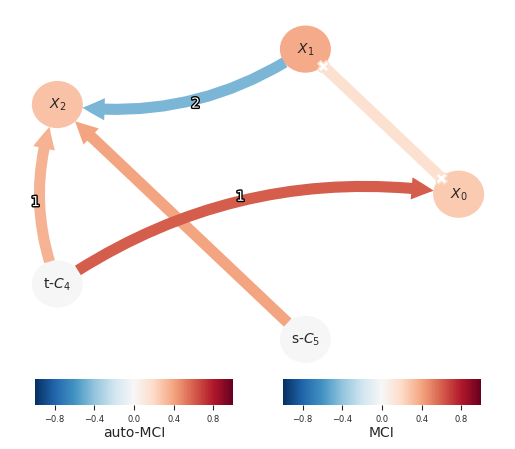

In [13]:
tp.plot_graph(results['graph'], val_matrix=results['val_matrix'], var_names=var_names)
plt.show()

The confounded link ``x-x`` with the `x`-edgemarks indicates that the orientation phase resulted in conflicting orientations when different rules where applied, see the PCMCIplus tutorial for details.

We suggest to first study toymodels that mimic the datasets of interest, but where causal ground truth is known. This helps to assess whether J-PCMCI$^+$ is applicable given, eg, too small sample sizes, and how to choose hyperparameters.

#### References

- [1] Joris M. Mooij, Sara Magliacane, and Tom Claassen. "Joint causal inference from multiple contexts." The Journal of Machine Learning Research 21.1 (2020): 3919-4026.
- [2] Biwei Huang, et al. "Causal discovery from heterogeneous/nonstationary data." The Journal of Machine Learning Research 21.1 (2020): 3482-3534.